In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# -------- Data Loading Function --------
def load_data(folder_path):
    all_data = []
    for file in sorted(os.listdir(folder_path)):
        if file.endswith('.csv'):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)
            if '5 Minutes' in df.columns and 'Flow (Veh/5 Minutes)' in df.columns:
                # Convert timestamp column to datetime
                df['5 Minutes'] = pd.to_datetime(df['5 Minutes'], errors='coerce')
                # Set timestamp as the index
                df = df.set_index('5 Minutes')
                # Append only the required column
                all_data.append(df[['Flow (Veh/5 Minutes)']])
    
    # Concatenate all dataframes
    combined_data = pd.concat(all_data)
    
    # Sort by the timestamp index
    combined_data = combined_data.sort_index()
    
    # Drop any rows with missing values
    combined_data = combined_data.dropna()
    
    return combined_data

In [3]:
# Load data for each node
folder_402214 = '../Data/402214'
folder_402510 = '../Data/402510'
folder_402835 = '../Data/402835'
folder_414025 = '../Data/414025'

data_402214 = load_data(folder_402214)
data_402510 = load_data(folder_402510)
data_402835 = load_data(folder_402835)
data_414025 = load_data(folder_414025)

# Find the common date range
common_start = max(data_402214.index.min(), data_402510.index.min(), data_402835.index.min(), data_414025.index.min())
common_end = min(data_402214.index.max(), data_402510.index.max(), data_402835.index.max(), data_414025.index.max())

# Create a common date range with 5-minute intervals
common_index = pd.date_range(start=common_start, end=common_end, freq='5T')

# Reindex and interpolate data for each node
data_402214 = data_402214.reindex(common_index).interpolate()
data_402510 = data_402510.reindex(common_index).interpolate()
data_402835 = data_402835.reindex(common_index).interpolate()
data_414025 = data_414025.reindex(common_index).interpolate()

# Stack the data for all nodes
node_data = np.stack([
    data_402214.values,
    data_402510.values,
    data_402835.values,
    data_414025.values
], axis=0)

# Normalize the data using MinMaxScaler
scalers = [MinMaxScaler() for _ in range(node_data.shape[0])]
for i in range(node_data.shape[0]):
    # Apply MinMaxScaler to each node's data, no need to flatten
    node_data[i] = scalers[i].fit_transform(node_data[i].reshape(-1, 1))

# Transpose the data to shape (num_timesteps, num_nodes, num_features)
node_data = np.transpose(node_data, (1, 0, 2))  # Shape: (num_timesteps, num_nodes, num_features)


In [4]:
# -------- 2. Create Adjacency Matrix --------
# Load the adjacency matrix (connectivity between nodes)
adj_matrix = pd.read_csv('../Data/adj.csv', header=None).values

# Normalize the adjacency matrix
def normalize_adjacency_matrix(adj):
    D = np.diag(np.sum(adj, axis=1))
    D_inv = np.linalg.inv(D)
    adj_normalized = np.dot(D_inv, adj)
    return adj_normalized

adj_normalized = normalize_adjacency_matrix(adj_matrix)
# Ensure adj_normalized is a PyTorch tensor with correct shape
adj_normalized = adj_normalized[:4, :4]  # Keep only the first 4x4 submatrix
adj_normalized = torch.tensor(adj_normalized, dtype=torch.float32)
print("Shape of adj_normalized:", adj_normalized.shape)

Shape of adj_normalized: torch.Size([4, 4])


In [5]:
# -------- 3. Prepare the Data --------
# Split the data into training, validation, and test sets
train_size = int(0.7 * len(node_data))
val_size = int(0.15 * len(node_data))
test_size = len(node_data) - train_size - val_size

train_data, val_data, test_data = np.split(node_data, [train_size, train_size + val_size])

# Create DataLoader for train, val, and test data
def create_dataloader(data, batch_size, input_window=10, output_window=5):
    X, Y = [], []
    for i in range(len(data) - input_window - output_window + 1):
        X.append(data[i:i+input_window])
        Y.append(data[i+input_window:i+input_window+output_window])
    X = torch.tensor(np.array(X), dtype=torch.float32)
    Y = torch.tensor(np.array(Y), dtype=torch.float32)
    dataset = TensorDataset(X, Y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

batch_size = 32
train_loader = create_dataloader(train_data, batch_size, input_window=10, output_window=5)
val_loader = create_dataloader(val_data, batch_size, input_window=10, output_window=5)
test_loader = create_dataloader(test_data, batch_size, input_window=10, output_window=5)


In [6]:
print("Shape of node_data:", node_data.shape)
train_loader = create_dataloader(train_data, batch_size)
val_loader = create_dataloader(val_data, batch_size)
test_loader = create_dataloader(test_data, batch_size)

# Print shapes of a batch from train_loader
for X_batch, Y_batch in train_loader:
    print("Shape of X_batch:", X_batch.shape)
    print("Shape of Y_batch:", Y_batch.shape)
    break

Shape of node_data: (24192, 4, 1)
Shape of X_batch: torch.Size([32, 10, 4, 1])
Shape of Y_batch: torch.Size([32, 5, 4, 1])


In [22]:
# -------- 4. Build the Model --------

# GCN Layer
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        # x shape: (batch_size, num_nodes, in_features)
        # adj shape: (num_nodes, num_nodes)

        # Multiply x with adjacency matrix on the node dimension
        out = torch.einsum('bni,nj->bni', x, adj)
        out = self.fc(out)
        return torch.relu(out)


# GCN Model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(input_dim, hidden_dim)
        self.gcn2 = GCNLayer(hidden_dim, output_dim)

    def forward(self, x, adj):
        x = self.gcn1(x, adj)
        x = self.gcn2(x, adj)
        return x

# Combined GNN + LSTM Model
class GNN_LSTM_Model(nn.Module):
    def __init__(self, num_nodes, input_dim, gnn_hidden_dim, lstm_hidden_dim, output_dim, output_window):
        super(GNN_LSTM_Model, self).__init__()
        self.gcn = GCN(input_dim, gnn_hidden_dim, gnn_hidden_dim)
        self.lstm = nn.LSTM(gnn_hidden_dim * num_nodes, lstm_hidden_dim, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_dim, num_nodes * output_dim * output_window)
        self.num_nodes = num_nodes
        self.output_dim = output_dim
        self.output_window = output_window

    def forward(self, x, adj):
        # x shape: (batch_size, input_window, num_nodes, input_dim)
        batch_size, input_window, num_nodes, input_dim = x.shape
        
        gnn_out = []
        for t in range(input_window):
            gnn_output = self.gcn(x[:, t, :, :], adj)  # (batch_size, num_nodes, gnn_hidden_dim)
            gnn_out.append(gnn_output)
        
        # Stack GNN outputs
        gnn_out = torch.stack(gnn_out, dim=1)  # (batch_size, input_window, num_nodes, gnn_hidden_dim)
        
        # Reshape for LSTM input
        lstm_in = gnn_out.view(batch_size, input_window, -1)
        
        # Pass through LSTM
        lstm_out, _ = self.lstm(lstm_in)  # (batch_size, input_window, lstm_hidden_dim)
        
        # Use only the last output from LSTM
        fc_in = lstm_out[:, -1, :]
        
        # Pass through fully connected layer
        fc_out = self.fc(fc_in)  # (batch_size, num_nodes * output_dim * output_window)
        
        # Reshape output to (batch_size, output_window, num_nodes, output_dim)
        output = fc_out.view(batch_size, self.output_window, self.num_nodes, self.output_dim)
        
        return output

# Model instantiation
num_nodes = 4
input_dim = 1
gnn_hidden_dim = 128
lstm_hidden_dim = 256
output_dim = 1
output_window = 5

model = GNN_LSTM_Model(num_nodes, input_dim, gnn_hidden_dim, lstm_hidden_dim, output_dim, output_window)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [23]:
print("Shape of adj_normalized:", adj_normalized.shape)

Shape of adj_normalized: torch.Size([4, 4])


In [24]:
# -------- 5. Train the Model --------
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pickle

def train_model(model, train_loader, val_loader, adj, num_epochs=10, patience=10):
    best_val_loss = float('inf')
    best_model = None
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        # Use tqdm for the progress bar
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for X_batch, Y_batch in train_bar:
            optimizer.zero_grad()

            # Forward pass
            predictions = model(X_batch, adj)
            loss = criterion(predictions, Y_batch)

            # Backpropagation
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
            # Update progress bar
            train_bar.set_postfix({'Train Loss': f'{train_loss/(train_bar.n+1):.4f}'})

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, Y_val in val_loader:
                val_predictions = model(X_val, adj)
                val_loss += criterion(val_predictions, Y_val).item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Check if this is the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
            
            # Save the best model
            torch.save(best_model, 'lstm_gcn_10_5.pth')
            
            # Save the MinMax scalers
            with open('scalers_lstm_gcn_10_5.pkl', 'wb') as f:
                pickle.dump(scalers, f)
            
            print(f"Saved new best model with validation loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
        
        # Early stopping
        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break

    return best_model

# Ensure adj_normalized is a PyTorch tensor with correct shape
adj_normalized = adj_normalized[:4, :4]  # Keep only the first 4x4 submatrix
adj_normalized = torch.tensor(adj_normalized, dtype=torch.float32)

best_model = train_model(model, train_loader, val_loader, adj_normalized, num_epochs=10, patience=10)

# Load the best model
model.load_state_dict(torch.load('lstm_gcn_10_5.pth'))

<ipython-input-24-ee2cb8911219>:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj_normalized = torch.tensor(adj_normalized, dtype=torch.float32)
Epoch 1/10: 100%|██████████| 529/529 [00:09<00:00, 55.30it/s, Train Loss=6263.1649] 


Epoch 1, Train Loss: 6203.9667, Val Loss: 4071.7028
Saved new best model with validation loss: 4071.7028


Epoch 2/10: 100%|██████████| 529/529 [00:10<00:00, 52.66it/s, Train Loss=4041.7125]


Epoch 2, Train Loss: 4026.4319, Val Loss: 4056.1610
Saved new best model with validation loss: 4056.1610


Epoch 3/10: 100%|██████████| 529/529 [00:10<00:00, 51.62it/s, Train Loss=4031.8717]


Epoch 3, Train Loss: 4031.8717, Val Loss: 4055.7917
Saved new best model with validation loss: 4055.7917


Epoch 4/10: 100%|██████████| 529/529 [00:09<00:00, 57.58it/s, Train Loss=4062.6721]


Epoch 4, Train Loss: 4031.9524, Val Loss: 4055.8700


Epoch 5/10: 100%|██████████| 529/529 [00:09<00:00, 57.61it/s, Train Loss=4062.8315]


Epoch 5, Train Loss: 4032.1106, Val Loss: 4055.9072


Epoch 6/10: 100%|██████████| 529/529 [00:09<00:00, 57.64it/s, Train Loss=4039.8097]


Epoch 6, Train Loss: 4032.1730, Val Loss: 4055.9294


Epoch 7/10: 100%|██████████| 529/529 [00:09<00:00, 56.29it/s, Train Loss=4032.2104]


Epoch 7, Train Loss: 4032.2104, Val Loss: 4055.9424


Epoch 8/10: 100%|██████████| 529/529 [00:09<00:00, 58.11it/s, Train Loss=4062.9540]


Epoch 8, Train Loss: 4032.2323, Val Loss: 4055.9499


Epoch 9/10: 100%|██████████| 529/529 [00:09<00:00, 57.57it/s, Train Loss=4039.8817]


Epoch 9, Train Loss: 4032.2449, Val Loss: 4055.9542


Epoch 10/10: 100%|██████████| 529/529 [00:09<00:00, 57.76it/s, Train Loss=4070.7275]


Epoch 10, Train Loss: 4032.2518, Val Loss: 4055.9566


<All keys matched successfully>

<All keys matched successfully>

In [25]:
# -------- 6. Test the Model --------
def evaluate_model(model, test_loader, adj):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_test, Y_test in test_loader:
            predictions = model(X_test, adj)
            test_loss += criterion(predictions, Y_test).item()
    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

evaluate_model(model, test_loader, adj_normalized)

Test Loss: 4204.5844


In [26]:
# -------- 7. Make Predictions --------
# To make predictions on new data
def predict(model, X_new, adj):
    model.eval()
    with torch.no_grad():
        return model(X_new, adj)

# Example prediction
new_data = torch.tensor(test_data[-10:].reshape(1, 10, 4, 1), dtype=torch.float32)  # Last 30 timesteps
predicted_flow_normalized = predict(model, new_data, adj_normalized)

# Inverse normalization (back to original scale)
predicted_flow = np.zeros_like(predicted_flow_normalized.detach().numpy())

# Apply inverse transform for each node
for i in range(num_nodes):
    # Reshape to 2D array for inverse_transform
    node_predictions = predicted_flow_normalized[0, :, i, 0].detach().numpy().reshape(-1, 1)
    predicted_flow[0, :, i, 0] = scalers[i].inverse_transform(node_predictions).flatten()

print("Non-normalized predicted flow for next 5 timesteps:")
for t in range(5):
    print(f"Timestep {t+1}:")
    for node in range(num_nodes):
        print(f"  Node {node+1}: {predicted_flow[0, t, node, 0]:.2f}")

Non-normalized predicted flow for next 5 timesteps:
Timestep 1:
  Node 1: 0.00
  Node 2: 0.00
  Node 3: 0.00
  Node 4: 0.00
Timestep 2:
  Node 1: 0.00
  Node 2: 0.00
  Node 3: 0.00
  Node 4: 0.00
Timestep 3:
  Node 1: 0.00
  Node 2: 0.00
  Node 3: 0.00
  Node 4: 0.00
Timestep 4:
  Node 1: 0.00
  Node 2: 0.00
  Node 3: 0.00
  Node 4: 0.00
Timestep 5:
  Node 1: 0.00
  Node 2: 0.00
  Node 3: 0.00
  Node 4: 0.00


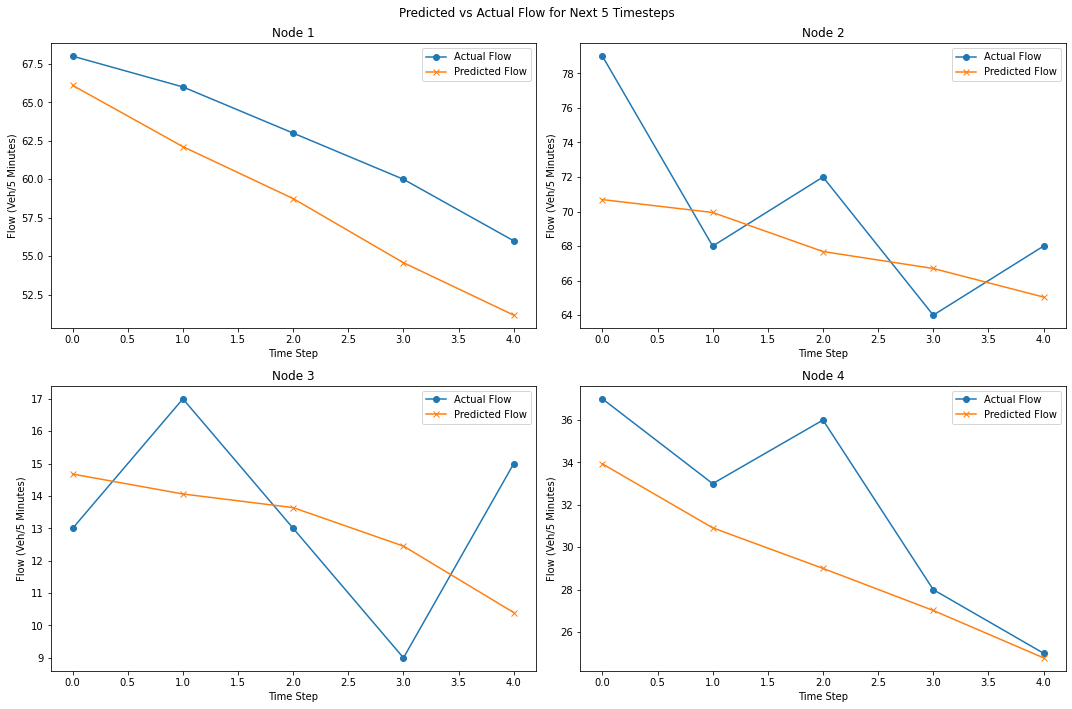

Mean Absolute Error (MAE): 3.3584
Root Mean Squared Error (RMSE): 3.9089
R-squared (R2) Score: 0.9721


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import time
# -------- 8. Visualize Training and Validation Loss --------
# This function remains unchanged as it's not directly related to the new plotting requirement

# -------- 9. Evaluate the Model on Test Set and Visualize Predictions --------
def evaluate_and_plot_results(model, test_loader, adj, scalers):
    model.eval()
    start = time.time()
    with torch.no_grad():
        # Get the last batch from the test loader
        for X_test, Y_test in test_loader:
            pass
        
        # Use the last 10 timesteps to predict the next 5
        input_sequence = X_test[-1:, :, :, :]  # Shape: [1, 10, num_nodes, 1]
        actual_next_5 = Y_test[-1:, :, :, :]  # Shape: [1, 5, num_nodes, 1]
        
        # Predict next 5 timesteps
        predicted_next_5 = model(input_sequence, adj)
        
        # Denormalize the predictions and actual values
        denorm_predictions = np.zeros_like(predicted_next_5.numpy())
        denorm_actuals = np.zeros_like(actual_next_5.numpy())
        
        for i in range(num_nodes):
            denorm_predictions[0, :, i, 0] = scalers[i].inverse_transform(
                predicted_next_5[0, :, i, 0].reshape(-1, 1)).flatten()
            denorm_actuals[0, :, i, 0] = scalers[i].inverse_transform(
                actual_next_5[0, :, i, 0].reshape(-1, 1)).flatten()
    
    # Plot predictions vs actual values for each node
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Predicted vs Actual Flow for Next 5 Timesteps')
    
    for i, ax in enumerate(axs.flat):
        ax.plot(range(5), denorm_actuals[0, :, i, 0], label='Actual Flow', marker='o')
        ax.plot(range(5), denorm_predictions[0, :, i, 0], label='Predicted Flow', marker='x')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Flow (Veh/5 Minutes)')
        ax.set_title(f'Node {i+1}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

    # Calculate evaluation metrics
    mae = mean_absolute_error(denorm_actuals.flatten(), denorm_predictions.flatten())
    rmse = np.sqrt(mean_squared_error(denorm_actuals.flatten(), denorm_predictions.flatten()))
    r2 = r2_score(denorm_actuals.flatten(), denorm_predictions.flatten())

    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'R-squared (R2) Score: {r2:.4f}')

# Evaluate model and plot results
evaluate_and_plot_results(model, test_loader, adj_normalized, scalers)

Time taken for prediction: 0.7020 seconds


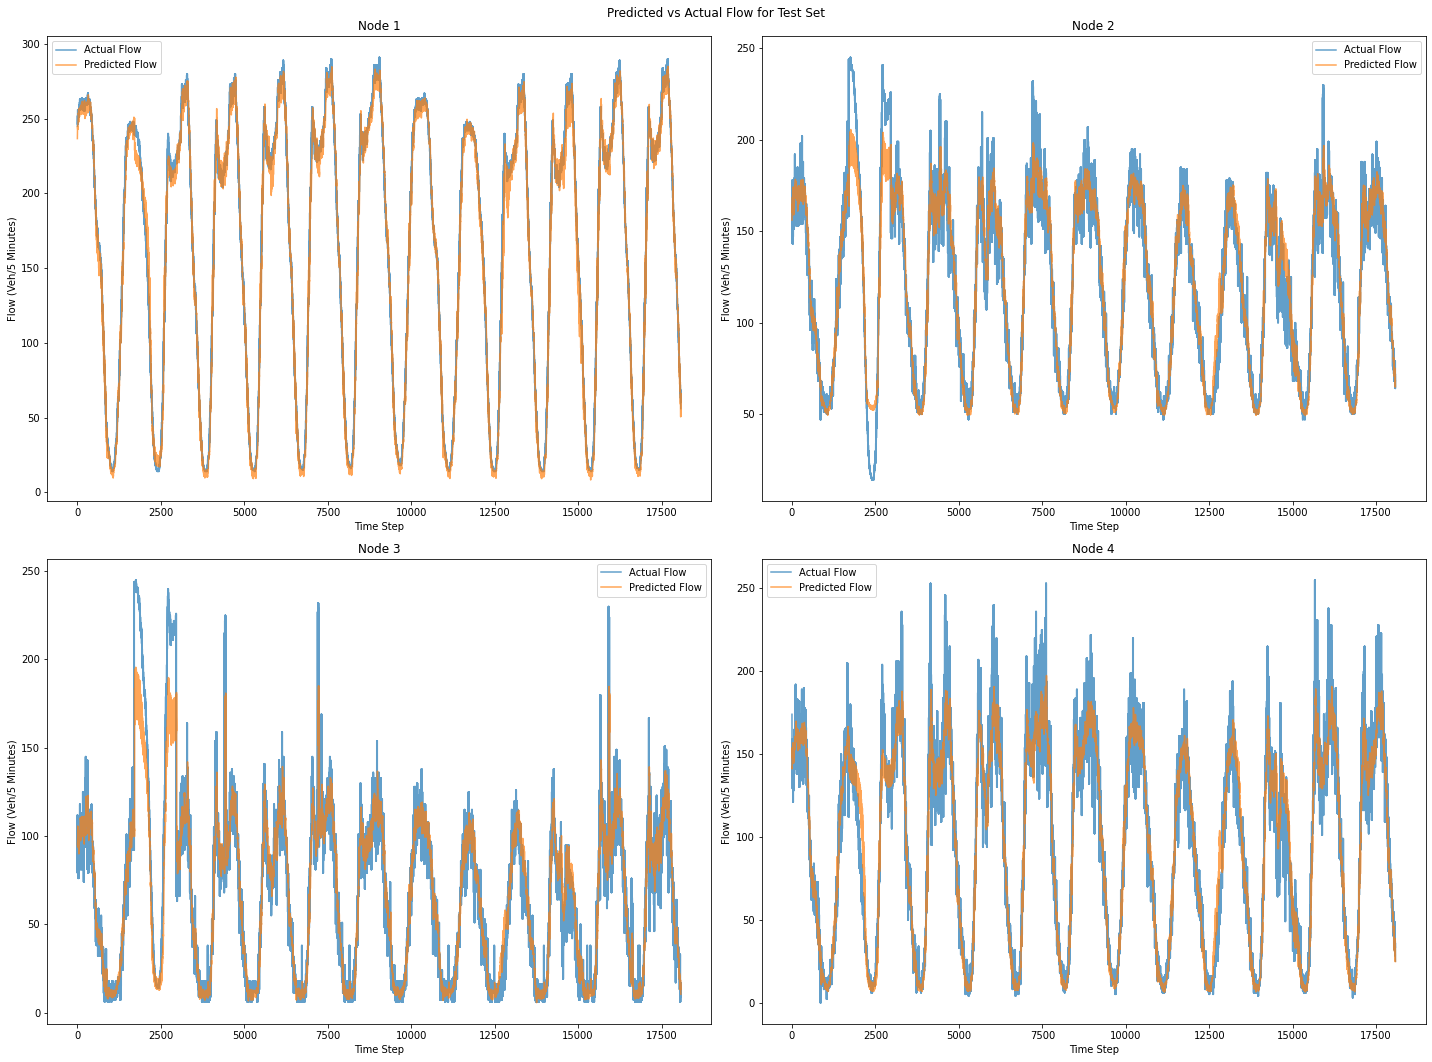

Mean Absolute Error (MAE): 10.2896
Root Mean Squared Error (RMSE): 15.3870
R-squared (R2) Score: 0.9565


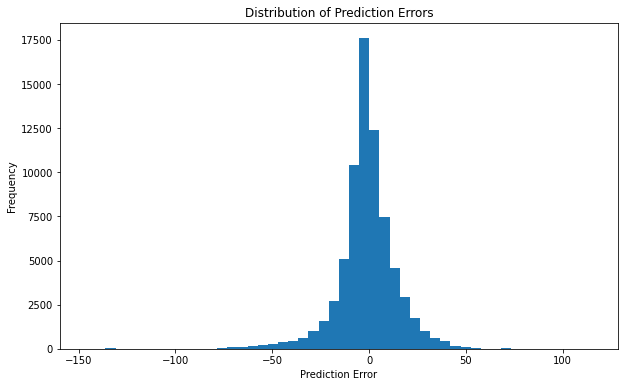

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import torch
import time  # To measure time

def evaluate_and_plot_results(model, test_loader, adj, scalers):
    model.eval()
    all_predictions = []
    all_actuals = []
    
    # Start time before predictions
    start_time = time.time()
    
    with torch.no_grad():
        for X_test, Y_test in test_loader:
            # Predict
            predictions = model(X_test, adj)
            
            # Store predictions and actuals
            all_predictions.append(predictions.cpu().numpy())
            all_actuals.append(Y_test.cpu().numpy())
    
    # End time after predictions
    end_time = time.time()
    prediction_time = end_time - start_time

    print(f'Time taken for prediction: {prediction_time:.4f} seconds')

    # Concatenate all batches
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_actuals = np.concatenate(all_actuals, axis=0)
    
    # Denormalize the predictions and actual values
    denorm_predictions = np.zeros_like(all_predictions)
    denorm_actuals = np.zeros_like(all_actuals)
    
    for i in range(num_nodes):
        denorm_predictions[:, :, i, 0] = scalers[i].inverse_transform(all_predictions[:, :, i, 0])
        denorm_actuals[:, :, i, 0] = scalers[i].inverse_transform(all_actuals[:, :, i, 0])
    
    # Plot predictions vs actual values for each node
    fig, axs = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle('Predicted vs Actual Flow for Test Set')
    
    for i, ax in enumerate(axs.flat):
        ax.plot(denorm_actuals[:, :, i, 0].flatten(), label='Actual Flow', alpha=0.7)
        ax.plot(denorm_predictions[:, :, i, 0].flatten(), label='Predicted Flow', alpha=0.7)
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Flow (Veh/5 Minutes)')
        ax.set_title(f'Node {i+1}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

    # Calculate evaluation metrics
    mae = mean_absolute_error(denorm_actuals.flatten(), denorm_predictions.flatten())
    rmse = np.sqrt(mean_squared_error(denorm_actuals.flatten(), denorm_predictions.flatten()))
    r2 = r2_score(denorm_actuals.flatten(), denorm_predictions.flatten())

    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'R-squared (R2) Score: {r2:.4f}')

    # Plot overall distribution of errors
    errors = denorm_predictions.flatten() - denorm_actuals.flatten()
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.show()

# Evaluate model and plot results
evaluate_and_plot_results(model, test_loader, adj_normalized, scalers)
